# Simulating stacks vs non-stacks

This is a notebook to test how stacking of galaxy clusters and hierarchical models work in triaxial clusters.

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
np.set_printoptions(linewidth=400)

In [3]:
import xlensing
from astropy.table import Table

Lookup table loaded!


In [4]:
mass = 1e14 # mass in Msun/h
concentration = 4.
nfw_z_halo = 0.3
RA = 0
DEC = 0


## Testing basic functions

In [5]:
xlensing.sims.rhoM(z=nfw_z_halo)

113160009026.94254

In [6]:
xlensing.sims.r_vir(nfw_z_halo, mass)

1.0179570954383914

In [7]:
xlensing.sims.critical_density(0.3,1.0)

array(4.04864605e+15)

In [8]:
xlensing.sims.NFW_tangential_shear(1e14, 4, 0.3, 1.0, .15)

array(0.02697304)

In [9]:
xlensing.sims.NFW_wcs_cluster_shear(1e14,4,0.3,1.0,0,0,0.000,-0.0003)

(0.024270067331205302-5.944452054450264e-18j)

In [10]:
gamma = xlensing.sims.NFW_wcs_cluster_shear(1e14,4,0.3,1.0,0,0,0.000,0.001)

xlensing.sims.add_shears(0.3+.0j,gamma)

(0.309372474969615+0j)

In [11]:
simplecat = xlensing.sims.make_simple_random_cat(10, width_rad=4./xlensing.cosmo.DA(0,0.3), zrange=[0.2,0.1], shape_noise=0.3)
simplecat = Table(simplecat.T,names=['ra','dec','z','e1','e2','R11','R12','R21','R22','w'])

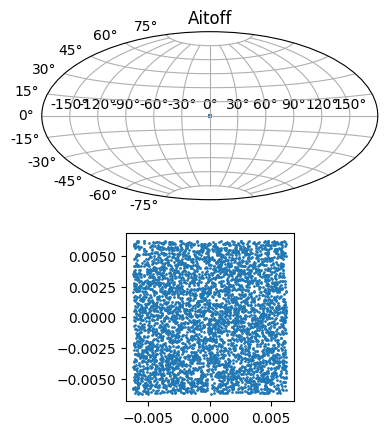

In [12]:
subplot(211, projection="aitoff")
scatter(simplecat['ra'],simplecat['dec'],s=1)
title("Aitoff")
grid(True)
subplot(212)
scatter(simplecat['ra'],simplecat['dec'],s=1)
ax = plt.gca()
ax.set_aspect('equal')

## 1 - Generate background galaxy catalogue

In [13]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/vitorelli/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [14]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import gc
# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS modules: cosmology and everything in the glass namespace
import glass.shells
import glass.fields
import glass.points
import glass.shapes
import glass.lensing
import glass.galaxies
import glass.observations
import glass.camb


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 512

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

In [15]:
# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 3., dx=200.)

# tophat window functions for shells
ws = glass.shells.tophat_windows(zb)

# compute the angular matter power spectra of the shells with CAMB
cls = glass.camb.matter_cls(pars, lmax, ws)

# compute Gaussian cls for lognormal fields for 3 correlated shells
# putting nside here means that the HEALPix pixel window function is applied
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

# generator for lognormal matter fields
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)

In [16]:
# this will compute the convergence field iteratively
convergence = glass.lensing.MultiPlaneConvergence(cosmo)

In [17]:
# galaxy density (using 1/100 of the expected galaxy number density for Stage-IV)
n_arcmin2 = 30.0

# true redshift distribution following a Smail distribution
z = np.arange(0., 3., 0.01)
dndz = glass.observations.smail_nz(z, z_mode=0.9, alpha=2., beta=1.5)
dndz *= n_arcmin2

# compute bin edges with equal density
nbins = 10
zedges = glass.observations.equal_dens_zbins(z, dndz, nbins=nbins)

# photometric redshift error
sigma_z0 = 0.03

# split distribution by tomographic bin, assuming photometric redshift errors
tomo_nz = glass.observations.tomo_nz_gausserr(z, dndz, sigma_z0, zedges)

# constant bias parameter for all shells
bias = 1.2

# ellipticity standard deviation as expected for a Stage-IV survey
sigma_e = 0.27


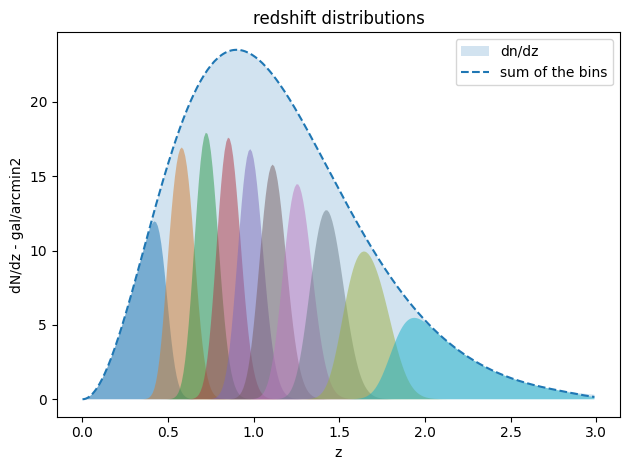

In [18]:
plt.figure()
plt.title('redshift distributions')
sum_nz = np.zeros_like(tomo_nz[0])
for nz in tomo_nz:
    plt.fill_between(z, nz, alpha=0.5)
    sum_nz = sum_nz + nz
plt.fill_between(z, dndz, alpha=0.2, label='dn/dz')
plt.plot(z, sum_nz, ls='--', label='sum of the bins')
plt.ylabel('dN/dz - gal/arcmin2')
plt.xlabel('z')
plt.legend()
plt.tight_layout()

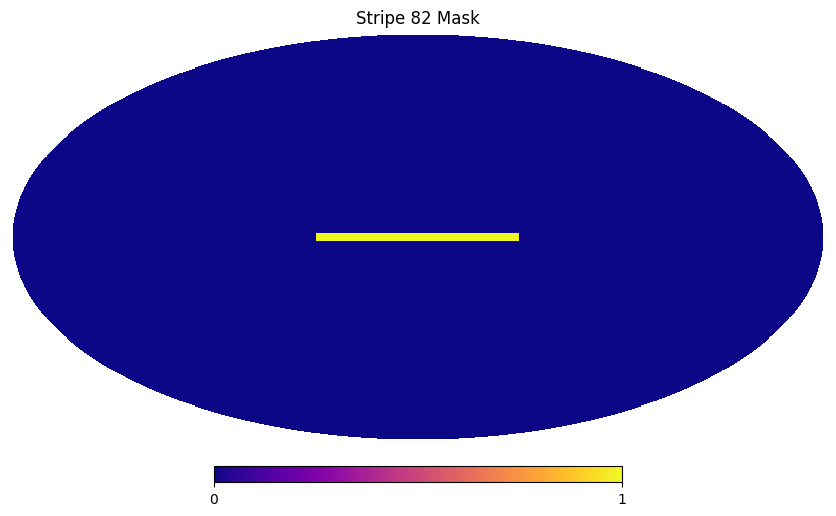

In [19]:
nside = 512
def mask_map_val(_nside,_ipix):
    """Mask loops and latitude"""
    l,b = hp.pix2ang(_nside,_ipix,lonlat=True)
    R = np.pi/180.
    cue = 0
    #STRIPE
    if ((l<45)or(l>315)) and (abs(b)<1.5):
      cue = 1

    return cue

mask_map = np.zeros(hp.nside2npix(nside))

for i in range(len(mask_map)):
    mask_map[i] = mask_map_val(nside, i)

# Presents the generated mask map
hp.mollview(mask_map, cmap='plasma',title="Stripe 82 Mask")

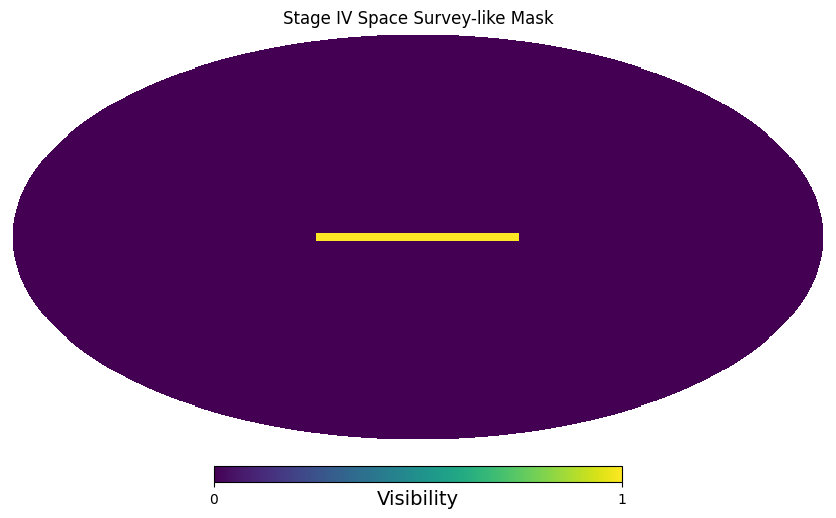

In [20]:
vis = mask_map

# checking the mask:
hp.mollview(vis, title='Stage IV Space Survey-like Mask', unit='Visibility')
plt.show()

In [21]:
# we will store the catalogue as a structured numpy array, initially empty
catalogue = np.empty(0, dtype=[('RA', float), ('DEC', float), ('TRUE_Z', float),
                               ('G1', float), ('G2', float), ('TOMO_ID', int)])
# simulate the matter fields in the main loop, and build up the catalogue
for i, delta_i in enumerate(matter):

    # compute the lensing maps for this shell
    convergence.add_window(delta_i, ws[i])
    kappa_i = convergence.kappa
    gamm1_i, gamm2_i = glass.lensing.shear_from_convergence(kappa_i)

    # the true galaxy distribution in this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i])

    # the photometric galaxy distribution in this shell
    tomo_z_i, tomo_nz_i = glass.shells.restrict(z, tomo_nz, ws[i])

    # integrate dndz to get the total galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)

    # generate galaxy positions from the matter density contrast
    gal_lon, gal_lat = glass.points.positions_from_delta(ngal, delta_i, bias, vis)

    # number of galaxies in this shell
    gal_siz = len(gal_lon)

    # generate random redshifts from the provided nz
    gal_z, gal_pop = glass.galaxies.redshifts_from_nz(gal_siz, tomo_z_i, tomo_nz_i)

    # generate galaxy ellipticities from the chosen distribution
    gal_eps = glass.shapes.ellipticity_intnorm(gal_siz, sigma_e)

    # apply the shear fields to the ellipticities
    gal_she = glass.galaxies.galaxy_shear(gal_lon, gal_lat, gal_eps,
                                          kappa_i, gamm1_i, gamm2_i)

    # make a mini-catalogue for the new rows
    rows = np.empty(gal_siz, dtype=catalogue.dtype)
    rows['RA'] = gal_lon
    rows['DEC'] = gal_lat
    rows['TRUE_Z'] = gal_z
    rows['G1'] = gal_she.real
    rows['G2'] = gal_she.imag
    rows['TOMO_ID'] = gal_pop

    # add the new rows to the catalogue
    catalogue = np.append(catalogue, rows)
    
    
print(f'Total Number of galaxies sampled: {len(catalogue["TRUE_Z"]):,}')
    


/home/vitorelli/github/glass/glass/galaxies.py:72: RuntimeWarning: invalid value encountered in divide
  cdf /= cdf[..., -1:]


Total Number of galaxies sampled: 29,755,556


In [22]:
cat=Table(catalogue)

In [23]:
cat.write("cs82_euclid.fits",overwrite=True)

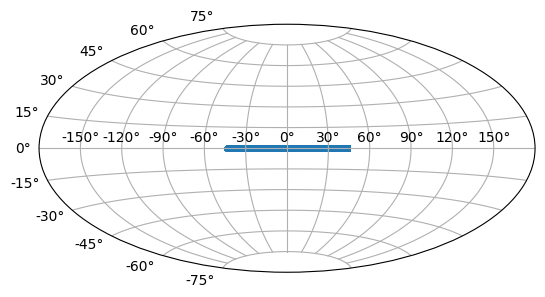

In [24]:
subplot(111,projection='aitoff')
scatter(np.radians(cat['RA']),np.radians(cat['DEC']),s=1)
grid(True)

In [25]:
cat

RA,DEC,TRUE_Z,G1,G2,TOMO_ID
float64,float64,float64,float64,float64,int64
1.870117671639003,1.4784286005131264,0.04160390555926867,-0.1437696930772774,0.08437280789016481,0
2.0260190444884247,1.547689918401801,0.010403836803174053,0.1636909208458146,-0.07346772702182087,0
2.336004545226356,1.5209444829596208,0.040967909318790074,-0.437886465661387,-0.2524416203336817,0
2.300756006607449,1.4842525879717243,0.013668316936162137,0.13345304884989856,-0.11575983399433964,0
2.4200611845746707,1.5092370270319435,0.04179851736877926,0.3440977766515576,0.028611394102358852,0
6.540268724656956,1.5164104942702323,0.024384003056978548,0.0008573883899905994,-0.3248377649774487,0
6.773972531843154,1.4470279915885413,0.026396092940951275,-0.17518390209641171,0.4135541849638644,0
8.130338718476638,1.4561600815856082,0.03441475208698372,-0.3564998545789515,0.12324942681878864,0
10.098560483710184,1.4269358531470147,0.04343803535174705,-0.1896658931367231,-0.050332253318156286,0


### Before testing with a proper cluster mass function...

In [33]:
clusters_RA = np.linspace(0,40,100)
clusters_DEC = np.random.uniform(-1,1,100)
clusters_M200 = np.random.normal(1e14,1e12,100)
clusters_C200 = np.random.uniform(3.,5.,100)
clusters_Z = np.random.uniform(.2,4,100)

In [34]:
clusters = Table([clusters_RA,
clusters_DEC,
clusters_M200,
clusters_C200,
clusters_Z,], names = ['RA','DEC','M200','C200','Z'])

In [35]:
clusters.write("clusters.fits",overwrite=True)

In [ ]:
def apply_cluster_cat_to_galaxies(clusters,galaxies,width):
  
  for cluster in clusters:
    #define a region mask
    mask = 
    #apply shear to mask
    
    #replace values in the catalogue with sheared values
    
    
  return galaxies
    
  

## Create Mass Function

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
import xlensing
import cluster_toolkit
from scipy import integrate
import camb
from scipy.interpolate import UnivariateSpline as USpline

In [30]:
# Cosmology and survey settings

# Same as CAMB demo
H0 = 67
ombh2 = 0.022
omch2 = 0.12
mnu = 0.06
omk = 0.
tau = 0.06
As = 2e-9
ns = 0.965
r = 0.

# From CAMB demo again
kmin = 1e-4 
kmax = 100.
nk = 10000

In [31]:
# Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
# This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=omk, tau=tau)
pars.InitPower.set_params(As=As, ns=ns, r=r)

# Calculate results for these parameters
results = camb.get_results(pars)

# Now get matter power spectra and sigma8 at redshift 0 and 0.8
# Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=10)

# Linear spectra
pars.NonLinear = camb.model.NonLinear_none
results = camb.get_results(pars)
kh, zs, pk = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
s8 = np.array(results.get_sigma8())

PowerSpec = USpline(kh,pk[0,:],s=0,k=5,ext=1)
# Non-Linear spectra (Halofit)
#pars.NonLinear = camb.model.NonLinear_both
#results.calc_power_spectra(pars)
#kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)

# Print some stuff out
print()
print(results.get_sigma8())


[0.7929439]


In [83]:
def Tinker_f(z,sigma):
  """Tinker et al. 2008"""
  A0 = 0.186
  a0 = 1.47
  b0 = 2.57
  c0 = 1.19
  Az = A0*(1+z)**-.14
  az = a0*(1+z)**-.06
  log10alpha200 = - (0.75/np.log10(200./75.))**1.2
  alpha = np.power(10,log10alpha200)
  bz = b0*(1+z)**alpha
  cz = c0
  f = Az*((sigma/bz)**-az + 1.)*np.exp(-cz/sigma**2.)
  return f

def sigma_squared(z,R):
    sigma2 = (xlensing.model.D(xlensing.cosmo.scale_factor(z))**2)*integrate.romberg(
        lambda k: ((k*k)/(19.7392))*PowerSpec(k)*xlensing.model.Window(k*R)**2,
        1e-4,
        1e4)#2*pi**2= 19.7392...
    return sigma2

def ln_inv_sigma(z,M):
  R = xlensing.model.r_vir_m(z,M*200)
  #sig2 = np.sqrt(sigma_squared(z,R200))
  
  sig = results.get_sigmaR(R)#np.sqrt(sig2)
  invsig = 1/sig
  lninvsig = np.log(invsig)
  return lninvsig

ln_inv_sigma = np.vectorize(ln_inv_sigma)

def dlninvsigmadM(z,M):
  deltaM =M/1000
  func = lambda m: ln_inv_sigma(z,m)
  derivative = (func(M+deltaM) - func(M)) /deltaM
  return derivative

def Tinker_mass_function(z,M):
  rhoMz = xlensing.cosmo.rhoM(z)
  R = xlensing.model.r_vir_m(z,M*200)
  sigma2 = results.get_sigmaR(R)**2
  #sigma = np.sqrt(sigma2)
  sigma = results.get_sigmaR(R)
  dndM = Tinker_f(z,sigma) * rhoMz/M * dlninvsigmadM(z,M)
  
  return dndM

In [84]:
masses = np.logspace(10,18,100)

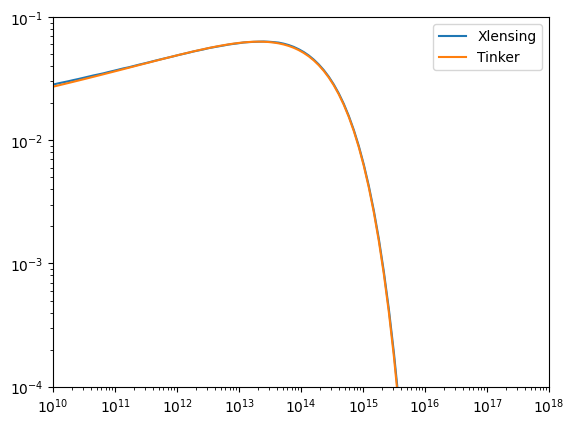

In [85]:
X = masses
Y1 = array([(mass)**2/xlensing.cosmo.rhoM(0.)*(Tinker_mass_function(0.,mass))for mass in masses]).reshape(100)
plot(X,Y1,label='Xlensing')
xscale('log')
yscale('log')
ylim(1e-4,1e-1)
xlim(1e10,1e18)

X = masses
Y2 = array([mass**2/xlensing.cosmo.rhoM(0.)*(cluster_toolkit.massfunction.dndM_at_M(mass,kh,pk,0.3))for mass in masses])
plot(X,Y2,label='Tinker')
xscale('log')
yscale('log')
ylim(1e-4,1e-1)
xlim(1e10,1e18)
legend()

(10000000000.0, 1e+18)

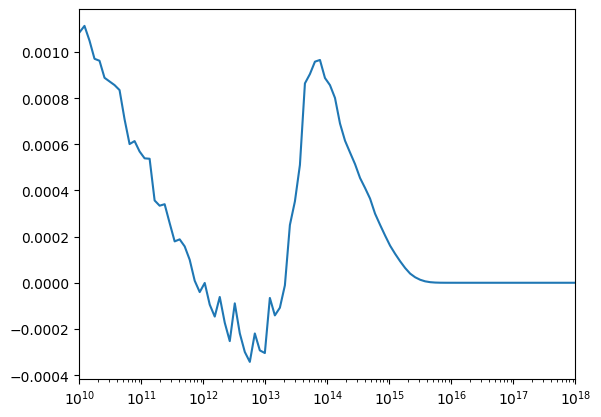

In [86]:
plot(masses,Y1-Y2)
xscale('log')
xlim(1e10,1e18)

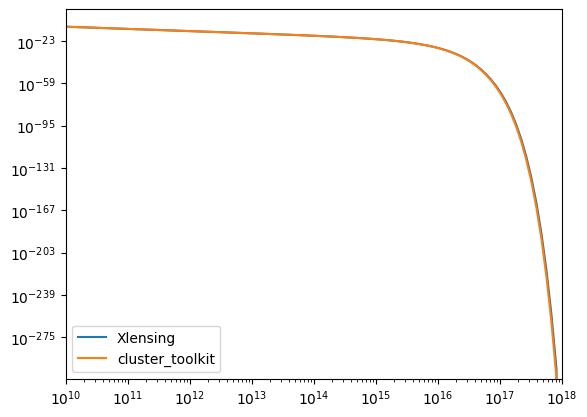

In [87]:
X = masses
Y1 = array([Tinker_mass_function(0.,mass)for mass in masses]).reshape(100)
plot(X,Y1,label='Xlensing')
xscale('log')
yscale('log')
#ylim(1e-4,1e-1)
xlim(1e10,1e18)

X = masses
Y2 = array([cluster_toolkit.massfunction.dndM_at_M(mass,kh,pk,0.3)for mass in masses])
plot(X,Y2,label='cluster_toolkit')
xscale('log')
yscale('log')
#ylim(1e-4,1e-1)
xlim(1e10,1e18)
legend()

In [118]:
def logistic_selection(M,m0=13,k=100):
  ls = 1./(1+np.exp(-k*(M-m0)))
  return ls
  

In [119]:
X = masses
Y3 = logistic_selection(np.log10(masses))

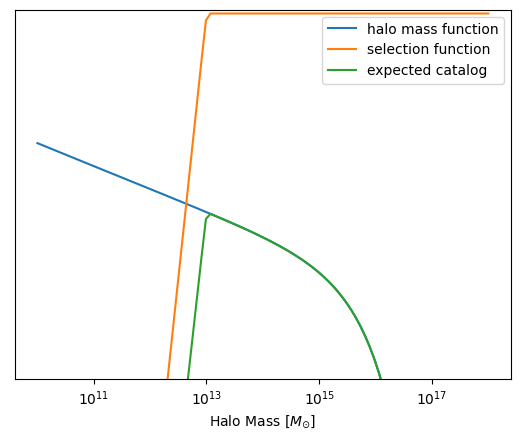

In [145]:
plot(X,Y1*1e12,label='halo mass function')
plot(X,Y3*1e12,label='selection function')
plot(X,Y3*Y1*1e12,label='expected catalog')
yscale('log')
xscale('log')
ylim(1e-18,2e12)
xlabel('Halo Mass $[ M_{\\odot} ]$ ')
plt.gca().set_yticks([])
legend()
savefig('catalog_probability_distribution.png',bbox_inches='tight')

Object `yaxis.set_tick_params` not found.


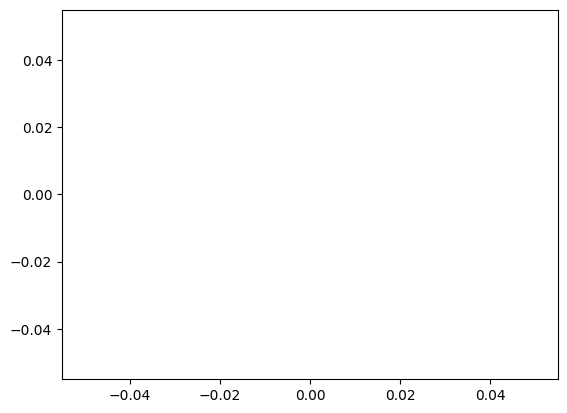

In [141]:
plot([0,0],[0,0])
plt.gca().yaxis.set_tick_params?

<bound method Axis.set_tick_params of <matplotlib.axis.YAxis object at 0x7fa9661b8e10>>

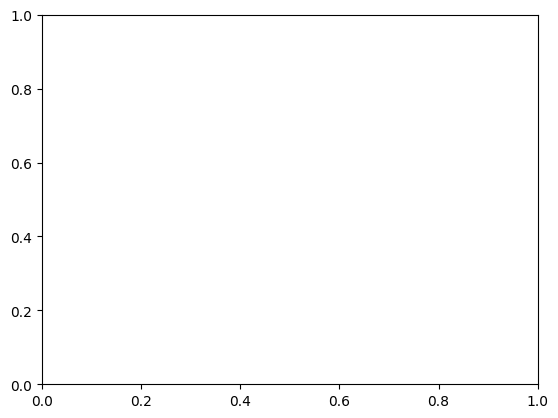